# Bayesian Neural Network

see: http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## Generating data

In [15]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((500, 2), (500, 2), (500,), (500,))

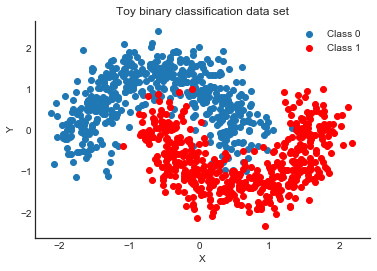

In [23]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set')

In [27]:
np.random.randn(5)

array([-0.09039189, -0.10871245, -1.88951327,  0.08179442, -0.9001307 ])

In [29]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden),testval=init_1) # Weights from input to hidden layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), testval=init_2) # Weights from 1st to 2nd layer
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden,), testval=init_out) # Weights from hidden layer to output

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', act_out, observed=ann_output, total_size=Y_train.shape[0]) # IMPORTANT for minibatches

    return neural_network

# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [32]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 135.24: 100%|██████████| 30000/30000 [00:14<00:00, 2094.51it/s]
Finished [100%]: Average Loss = 135.4


CPU times: user 18.8 s, sys: 843 ms, total: 19.6 s
Wall time: 42.1 s


In [33]:
%%time

with neural_network:
    advifit = pm.advi(n=30000)

Average ELBO = -165.66: 100%|██████████| 30000/30000 [00:08<00:00, 3462.59it/s]
Finished [100%]: Average ELBO = -148.23


CPU times: user 11.4 s, sys: 1.29 s, total: 12.7 s
Wall time: 59.6 s


In [34]:
trace = approx.sample(draws=5000)

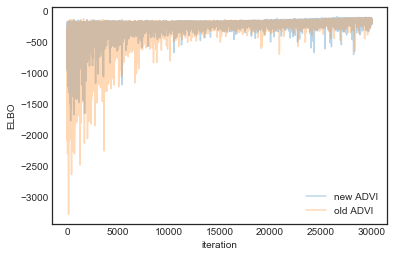

In [36]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(advifit.elbo_vals, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')